## Практическое задание к уроку 3 по теме "Dataset, Dataloader, BatchNorm, Dropout, Оптимизация".

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import sklearn.datasets
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_STATE = 29

Напишем класс для загрузки данных, сразу сделаем разбиение на train/test:

In [3]:
class CaliforniaDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.dataset = sklearn.datasets.fetch_california_housing(return_X_y=True)
        
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.dataset[0], self.dataset[1], random_state=13, test_size=0.25)
        
        self.suffix = '_train' if train else '_test'
        self.X = torch.Tensor(eval(f'self.X{self.suffix}'))
        self.y = torch.Tensor(eval(f'self.y{self.suffix}'))
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Загрузим данные:

In [4]:
train_dataset = CaliforniaDataset()
test_dataset = CaliforniaDataset(train=False)

In [5]:
len(train_dataset), len(test_dataset)

(15480, 5160)

Обернём в Dataloader. Не будем делать shuffle на трейне, т.к.  
перемешивание уже делается в train_test_split при загрузке данных.

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=64,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False)

Напишем сеть, состоящую из двух скрытых слоёв. Добавим дропаут и  
батч-нормализацию:

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        torch.random.manual_seed(RANDOM_STATE)
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = nn.Linear(input_dim, 2 * hidden_dim)
        self.fc2 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

Напишем функцию для обучения сети. В качестве входных параметров она будет  
принимать тип оптимизатора, что необходимо нам по заданию. Был значительно  
переработан код обучения модели с урока, в том числе исправлены ошибки с  
выводом лосса и метрики на трейне. В качестве лосса используем MSE, а в  
качестве метрики - R2.

In [8]:
def train_nn(opt='adam', epochs=100, verbose=1):

    input_shape = iter(train_loader).next()[0].shape[1]
    net = Net(input_shape, 128)
    criterion = nn.MSELoss()
    match opt:
        case 'adam':
            optimizer = optim.Adam(net.parameters())
        case 'rmsprop':
            optimizer = optim.RMSprop(net.parameters())
        case 'sgd':
            optimizer = optim.SGD(net.parameters(), lr=0.0001)

    metrics_train_global = np.array([])
    metrics_test_global = np.array([])

    for epoch in range(epochs):  
        net.train()
        metrics_train = np.array([])
        metrics_test = np.array([])
        losses = np.array([])

        for i, data in enumerate(train_loader):
            X, y = data[0], data[1]

            optimizer.zero_grad()

            outputs = net(X)
            loss = criterion(outputs, y.view(-1, 1))
            loss.backward()
            optimizer.step()

            net.eval()
            metrics_train = np.append(metrics_train, r2_score(y.detach().numpy(), net(X).detach().numpy()))
            losses = np.append(losses, loss.item())
        
        if (verbose == 1 and (epoch+1) % 10 == 0) or verbose == 2:
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Loss: {losses.mean():.4f}. '\
                  f'Train R2: {metrics_train.mean():.4f}. ', end='')

        for i, data in enumerate(test_loader):
            X, y = data[0], data[1]
            metrics_test = np.append(metrics_test, r2_score(y.detach().numpy(), net(X).detach().numpy()))    
        
        if (verbose == 1 and (epoch+1) % 10 == 0) or verbose == 2:
            print(f'Test R2: {metrics_test.mean():.4f}')    
        
        metrics_train_global = np.append(metrics_train_global, metrics_train.mean())
        metrics_test_global = np.append(metrics_test_global, metrics_test.mean())
    print('Training is finished!')
    return metrics_train_global, metrics_test_global

Оптимизаторы будем использовать на параметрах по умолчанию. Только в  
SGD зададим скорость обучения, так как она по умолчанию не задаётся.  
learning_rate выбран достаточно малым, так как при бОльших значениях  
модель не сходилась.

In [9]:
train_adam, test_adam = train_nn(opt='adam', epochs=200, verbose=1)

Epoch [10/200]. Loss: 0.5523. Train R2: 0.5680. Test R2: 0.5773
Epoch [20/200]. Loss: 0.4411. Train R2: 0.6608. Test R2: 0.6375
Epoch [30/200]. Loss: 0.3691. Train R2: 0.7191. Test R2: 0.6953
Epoch [40/200]. Loss: 0.3894. Train R2: 0.7393. Test R2: 0.7210
Epoch [50/200]. Loss: 0.3005. Train R2: 0.7713. Test R2: 0.7475
Epoch [60/200]. Loss: 0.2828. Train R2: 0.7678. Test R2: 0.7520
Epoch [70/200]. Loss: 0.2675. Train R2: 0.7930. Test R2: 0.7640
Epoch [80/200]. Loss: 0.2605. Train R2: 0.7989. Test R2: 0.7705
Epoch [90/200]. Loss: 0.2523. Train R2: 0.7984. Test R2: 0.7727
Epoch [100/200]. Loss: 0.2479. Train R2: 0.8091. Test R2: 0.7742
Epoch [110/200]. Loss: 0.2415. Train R2: 0.8127. Test R2: 0.7741
Epoch [120/200]. Loss: 0.2360. Train R2: 0.8021. Test R2: 0.7734
Epoch [130/200]. Loss: 0.2363. Train R2: 0.8193. Test R2: 0.7808
Epoch [140/200]. Loss: 0.2339. Train R2: 0.8201. Test R2: 0.7806
Epoch [150/200]. Loss: 0.2267. Train R2: 0.8249. Test R2: 0.7787
Epoch [160/200]. Loss: 0.2391. Tra

In [10]:
train_rms, test_rms = train_nn(opt='rmsprop', epochs=200, verbose=0)

Training is finished!


In [11]:
train_sgd, test_sgd = train_nn(opt='sgd', epochs=1000, verbose=0)

Training is finished!


Посмотрим на процесс обучения модели с каждым оптимизатором:

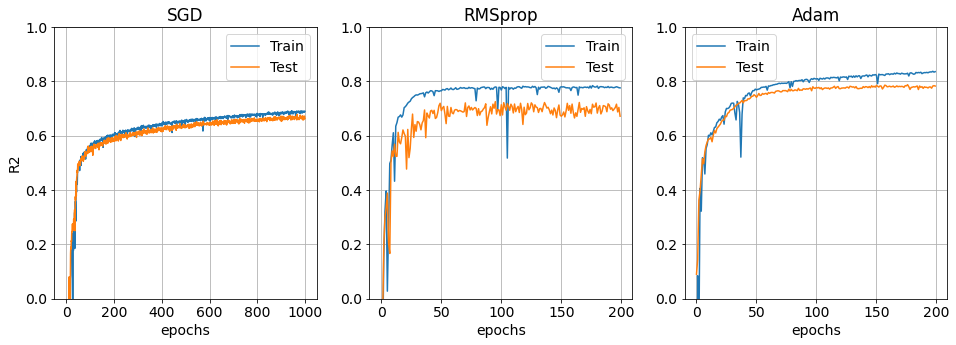

In [12]:
plt.figure(figsize=(16, 5))
plt.rcParams.update({'font.size': 14})

plt.subplot(1, 3, 1)
plt.plot(range(len(train_sgd)), train_sgd, label='Train')
plt.plot(range(len(test_sgd)), test_sgd, label='Test')
plt.title('SGD')
plt.ylabel('R2')
plt.xlabel('epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(len(train_rms)), train_rms, label='Train')
plt.plot(range(len(test_rms)), test_rms, label='Test')
plt.title('RMSprop')
plt.xlabel('epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(len(train_adam)), train_adam, label='Train')
plt.plot(range(len(test_adam)), test_adam, label='Test')
plt.title('Adam')
plt.xlabel('epochs')
plt.ylim([0, 1])
plt.grid()
plt.legend()

plt.show()

SGD продолжает получать эффект от увеличения количества эпох, в то время как  
RMSprop и Adam движутся в сторону переобучения. Для RMSprop оптимальным количеством  
оказалось около 50 эпох, а для Adam - 50-100. Также отметим, что RMSprop имеет  
очень нестабильную метрику на тесте.

Теперь сравним процесс обучения модели с каждым рассматриваемым оптимизатором.  
Чтобы оставить график читаемым, будем рассматривать метрику только на тесте:

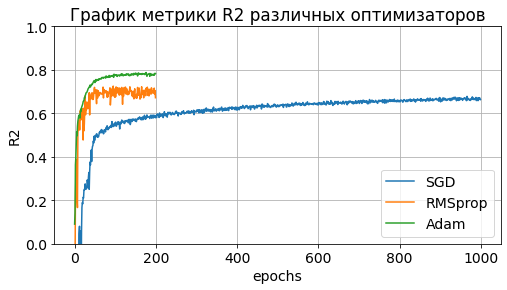

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_sgd)), test_sgd, label='SGD')
plt.plot(range(len(test_rms)), test_rms, label='RMSprop')
plt.plot(range(len(test_adam)), test_adam, label='Adam')
plt.title('График метрики R2 различных оптимизаторов')
plt.xlabel('epochs')
plt.ylabel('R2')
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

Изменим масштаб:

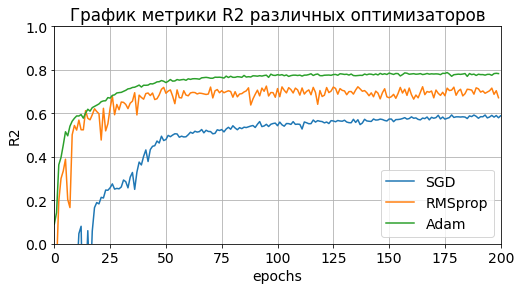

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(test_sgd)), test_sgd, label='SGD')
plt.plot(range(len(test_rms)), test_rms, label='RMSprop')
plt.plot(range(len(test_adam)), test_adam, label='Adam')
plt.title('График метрики R2 различных оптимизаторов')
plt.xlabel('epochs')
plt.ylabel('R2')
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

Лучшим оптимизатором оказался Adam. Несмотря на то, что модель с SGD  
продолжает улучшаться с увеличением числа эпох, маловероятно, что её результат  
приблизится к результату модели с Adam (даже 1000 эпох не хватило). Модель с  
RMSprop показала неплохой средний результат, но метрика слишком нестабильна.  
Возможно, тонкая настройка гиперпараметров оптимизаторов изменит картину,  
но это не являлось нашей задачей, и это чревато подстройкой под конкретную  
выборку. Для проведения таких настроек нужно следить за обучением на нескольких  
выборках сразу, в том числе с помощью кросс-валидации.